In [ ]:
import zipfile
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/Colab Notebooks/eye_quality/processed.zip", 'r')
zip_ref.extractall("/content/drive/MyDrive/Colab Notebooks/eye_quality/")
zip_ref.close()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install pytorch-lightning timm torchinfo

In [ ]:
root_dir = '/content/drive/MyDrive/Colab Notebooks/eye_quality'

In [1]:
root_dir = '/home/tiurin/projects/ExampleProject/Temp/'

In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append('/home/tiurin/projects/ExampleProject/Temp/code/eye_quality/')

In [4]:
import dataset_utils

In [5]:
import evaluation_utils

In [6]:
from torch.utils.data import Subset,DataLoader
from torchvision import transforms, utils
import torchvision
import torch

In [7]:
import torch.nn.functional as F

In [8]:
import os

In [9]:
import numpy as np

In [10]:
import pytorch_lightning as pl

In [11]:
# Setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Global seed set to 42


In [12]:
train_set, val_set, class_weights = dataset_utils.get_dataset(train_percent=0.9, 
                                                              rotation_transform=True,
                                                             zoom_augment=True)

#train_set = Subset(train_set, torch.arange(100))
#val_set = Subset(val_set, torch.arange(100))

train_loader = DataLoader(train_set, batch_size=24, shuffle=True,
                               drop_last=True, pin_memory=True, num_workers=8)
val_loader = DataLoader(val_set, batch_size=24, shuffle=False,
                             drop_last=False, num_workers=8)

In [13]:
#device = torch.device("cpu")

In [14]:
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:2")
print("Using device", device)

Using device cuda:2


In [15]:
import torchinfo

In [16]:
from torch import optim, nn
import timm
import torchmetrics

In [17]:
class STNet(nn.Module):
    def __init__(self):
        super(STNet, self).__init__()
        
        self.localization = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=7),
            nn.MaxPool2d(5, stride=5),
            nn.ReLU(),
            nn.Conv2d(8, 10, kernel_size=5),
            nn.MaxPool2d(5, stride=5),
            nn.ReLU(),
            nn.Conv2d(10, 10, kernel_size=3),
            nn.MaxPool2d(3, stride=3),
            nn.ReLU()
        )
        
        self.fc_loc = nn.Sequential(
            nn.Linear(160, 32),
            nn.ReLU(),
            nn.Linear(32, 2)
        )
        
        def _init_weights(m):
            if isinstance(m, (nn.Linear, nn.Conv2d)):
                torch.nn.init.xavier_uniform_(m.weight)
                m.bias.data.fill_(0.0)
        
        self.localization.apply(_init_weights)
        
        torch.nn.init.xavier_uniform_(self.fc_loc[0].weight)
        self.fc_loc[0].bias.data.fill_(0.0)
        
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([0, 1], dtype=torch.float))
    
    def forward(self, x, mask=None):
        tnsfm = self.get_transform(x, mask)
        x = self.transform(x, tnsfm)
        return x
    
    def get_transform(self, x, mask=None):
        xs = self.localization(x)
        xs = xs.view(x.shape[0], -1)
        transformer = self.fc_loc(xs)
        transformer = transformer.view(x.shape[0], 2)
        
        if mask is not None:
            transformer[mask==False] = torch.tensor([0, 1], dtype=torch.float).to(x.device)   
        
        transformer[:, 1] = F.relu(transformer[:, 1])
        transformer[:, 1] += 0.000000001
        
        theta = torch.zeros(transformer.shape[0], 2, 3).to(x.device)
        
        cos_val = torch.cos(transformer[:, 0])
        sin_val = torch.sin(transformer[:, 0])
        theta[:, 0, 0] = cos_val
        theta[:, 0, 1] = sin_val
        theta[:, 1, 0] = -sin_val
        theta[:, 1, 1] = cos_val
        theta[:, 0, 0] *= transformer[:,1]
        theta[:, 0, 1] *= transformer[:,1]
        theta[:, 1, 0] *= transformer[:,1]
        theta[:, 1, 1] *= transformer[:,1]
        
        return theta
    
    def transform(self, x, theta):
        x = dataset_utils.inverse_transform(x)
        grid = F.affine_grid(theta, x.size(), align_corners=False)
        x = F.grid_sample(x, grid, align_corners=False)
        x = dataset_utils.normalize(x)
        return x

In [18]:
stn = STNet()
stn = stn.to(device)

In [19]:
torchinfo.summary(stn, (32, 1, 400, 400), device=device)

Layer (type:depth-idx)                   Output Shape              Param #
STNet                                    [32, 1, 400, 400]         --
├─Sequential: 1-1                        [32, 10, 4, 4]            --
│    └─Conv2d: 2-1                       [32, 8, 394, 394]         400
│    └─MaxPool2d: 2-2                    [32, 8, 78, 78]           --
│    └─ReLU: 2-3                         [32, 8, 78, 78]           --
│    └─Conv2d: 2-4                       [32, 10, 74, 74]          2,010
│    └─MaxPool2d: 2-5                    [32, 10, 14, 14]          --
│    └─ReLU: 2-6                         [32, 10, 14, 14]          --
│    └─Conv2d: 2-7                       [32, 10, 12, 12]          910
│    └─MaxPool2d: 2-8                    [32, 10, 4, 4]            --
│    └─ReLU: 2-9                         [32, 10, 4, 4]            --
├─Sequential: 1-2                        [32, 2]                   --
│    └─Linear: 2-10                      [32, 32]                  5,152
│    └─

In [20]:
class EyeQualityModel(pl.LightningModule):
    def __init__(self, class_weights=None):
        super().__init__()
        
        self.stn = STNet()
        
        self.net = timm.create_model('mobilenetv3_small_100', pretrained=True, in_chans=1)
        self.net.classifier = nn.Identity()
        self.classifier = nn.Linear(1024, 2)
        
        torch.nn.init.xavier_uniform_(self.classifier.weight)
        self.classifier.bias.data.fill_(0.0)
        
        self.class_weights = class_weights
        #self.example_input_array = train_set[0][1].unsqueeze(0)
        
    def forward(self, x, mask=None):
        x = self.stn(x, mask)
        x = self.net(x)
        x = self.classifier(x)
        return x
    
    def ordinal_regression(self, predictions, targets):
        modified_target = torch.zeros_like(predictions)
        for i, target in enumerate(targets):
            if target > 0:
                modified_target[i, 0:target] = 1
        loss = torch.nn.functional.binary_cross_entropy_with_logits(predictions,
                                                                    modified_target,
                                                                    reduction='none').sum(dim=1)
        if self.class_weights is not None:
            for i, target in enumerate(targets):
                loss[i] *= self.class_weights[target]
        return loss.mean()
    
    def predict(self, img):
        x = self.forward(img)
        c = self.prediction2label(x)
        return c

    def prediction2label(self, pred: np.ndarray):
        pred = torch.sigmoid(pred)
        return torch.clamp((pred > 0.5).cumprod(axis=1).sum(axis=1), min=0)
    
    def training_step(self, batch, batch_idx):
        class_lbl, img = batch
        
        #if batch_idx == 0:
        #    self.stn = self.stn.to(self.device)
        
        #mask_use_for_stn = class_lbl > 0
        mask_use_for_stn = None
        c = self.forward(img, mask_use_for_stn)
        
        loss = self.ordinal_regression(c, class_lbl)
        self.log("train_loss", loss)
        
        if batch_idx % 100 == 0:
            x_tnsfm = self.stn(img)
            x_tnsfm = dataset_utils.convert_to_image(x_tnsfm[:9, :, :, :])
            img_grid_out = evaluation_utils.make_image_grid(x_tnsfm)
            img_grid_out = img_grid_out.astype(float) / 255
            img_ = dataset_utils.convert_to_image(img[:9, :, :, :])
            img_grid_in = evaluation_utils.make_image_grid(img_)
            img_grid_in = img_grid_in.astype(float) / 255
           
            img_grid = (img_grid_out - img_grid_in + 1.0)/2.0
            
            self.logger.experiment.add_image("STN output diff", img_grid, self.current_epoch*800 + batch_idx, dataformats="CHW")
            
        return loss
    
    def validation_step(self, batch, batch_idx):
        class_lbl, img = batch
        c = self.forward(img)
        loss = self.ordinal_regression(c, class_lbl)
        self.log("val_loss", loss)
        res = torch.vstack([self.prediction2label(c), class_lbl])
        return res
    
    def validation_epoch_end(self, validation_step_outputs):
        all_preds = torch.hstack(validation_step_outputs)
        conf_mat = evaluation_utils.get_confusion_matrix(all_preds[0,:], all_preds[1,:])
        self.log("val_accuracy", evaluation_utils.accuracy(conf_mat))
        self.log("val_recall", evaluation_utils.recall(conf_mat))
        self.log("val_precision", evaluation_utils.precision(conf_mat))
        self.log("val_f1_score", evaluation_utils.f1_score(conf_mat))
        self.log("val_class_accuracy_0", evaluation_utils.class_accuracy(conf_mat, 0))
        self.log("val_class_accuracy_1", evaluation_utils.class_accuracy(conf_mat, 1))
        self.log("val_class_accuracy_2", evaluation_utils.class_accuracy(conf_mat, 2))
        
        fig = evaluation_utils.plot_confusion_matrix(conf_mat, ['Reject', 'Usable', 'Good'])
        img = evaluation_utils.plot_to_image(fig)
        
        img = img.astype(float) / 255
        self.logger.experiment.add_image("Confusion matrix", img, self.current_epoch, dataformats="CHW")

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=1e-4)
        scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
        return [optimizer], [scheduler]

In [21]:
class_weights

tensor([1.3010, 2.9717, 1.8380])

In [22]:
model = EyeQualityModel(class_weights)
model = model.to(device)

In [23]:
#model = EyeQualityModel()

In [24]:
torchinfo.summary(model, (1, 1, 400, 400), device=device)

Layer (type:depth-idx)                             Output Shape              Param #
EyeQualityModel                                    [1, 2]                    --
├─STNet: 1-1                                       [1, 1, 400, 400]          --
│    └─Sequential: 2-1                             [1, 10, 4, 4]             --
│    │    └─Conv2d: 3-1                            [1, 8, 394, 394]          400
│    │    └─MaxPool2d: 3-2                         [1, 8, 78, 78]            --
│    │    └─ReLU: 3-3                              [1, 8, 78, 78]            --
│    │    └─Conv2d: 3-4                            [1, 10, 74, 74]           2,010
│    │    └─MaxPool2d: 3-5                         [1, 10, 14, 14]           --
│    │    └─ReLU: 3-6                              [1, 10, 14, 14]           --
│    │    └─Conv2d: 3-7                            [1, 10, 12, 12]           910
│    │    └─MaxPool2d: 3-8                         [1, 10, 4, 4]             --
│    │    └─ReLU: 3-9         

In [25]:
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor

In [26]:
checkpoint_path = os.path.join(root_dir, 'training')
model_name = 'eyeq_model_new_dataset_mbl'
root_dir_pl = os.path.join(checkpoint_path, model_name)

In [27]:
trainer = pl.Trainer(default_root_dir=root_dir_pl,
    accelerator="gpu", devices=[device.index], 
    max_epochs=10,
    callbacks=[ModelCheckpoint(dirpath=root_dir_pl, 
                filename=model_name+'-{epoch}-{val_accuracy:.2f}', 
                save_weights_only=True, 
                save_last=True),
                LearningRateMonitor("epoch")],
    check_val_every_n_epoch=1)

trainer.logger._log_graph = True
trainer.logger._default_hp_metric = None

trainer.fit(model, train_loader, val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/tiurin/anaconda3/envs/mri_gpu/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint directory /share/data_rechenknecht03_2/students/tiurin/projects/ExampleProject/Temp/training/eyeq_model_new_dataset_mbl exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name       | Type        | Params
-------------------------------------------
0 | stn        | STNet       | 8.5 K 
1 | net        | MobileNetV3 | 1.5 M 
2 | classifier | Linear      | 2.0 K 
-------------------------------------------
1.5 M     Trainable params
0         Non-trainable params
1.5 M     Total params
6.113     Total estimated model params size (MB)
/home/tiurin/anaconda3/envs/mri_gpu/lib/python3.10/site-packages/

Sanity Checking: 0it [00:00, ?it/s]

/home/tiurin/projects/ExampleProject/Temp/code/eye_quality/evaluation_utils.py:104: RuntimeWarning: invalid value encountered in long_scalars
  averageRecall += confusionMat[idx,idx]/np.sum(confusionMat[idx,:])
/home/tiurin/projects/ExampleProject/Temp/code/eye_quality/evaluation_utils.py:93: RuntimeWarning: invalid value encountered in long_scalars
  averagePrecision += confusionMat[idx,idx]/np.sum(confusionMat[:,idx])
/home/tiurin/projects/ExampleProject/Temp/code/eye_quality/evaluation_utils.py:123: RuntimeWarning: invalid value encountered in long_scalars
  return confusion_mat[class_num, class_num]/confusion_mat[class_num,:].sum()


Training: 0it [00:00, ?it/s]

RuntimeError: Caught RuntimeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/tiurin/anaconda3/envs/mri_gpu/lib/python3.10/site-packages/torch/utils/data/_utils/worker.py", line 302, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/tiurin/anaconda3/envs/mri_gpu/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 58, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/tiurin/anaconda3/envs/mri_gpu/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 58, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/tiurin/anaconda3/envs/mri_gpu/lib/python3.10/site-packages/torch/utils/data/dataset.py", line 240, in __getitem__
    return self.datasets[dataset_idx][sample_idx]
  File "/home/tiurin/projects/ExampleProject/Temp/code/eye_quality/dataset_utils.py", line 156, in __getitem__
    sample = torchvision.io.read_image(image_path).to(torch.float32)
  File "/home/tiurin/anaconda3/envs/mri_gpu/lib/python3.10/site-packages/torchvision/io/image.py", line 253, in read_image
    data = read_file(path)
  File "/home/tiurin/anaconda3/envs/mri_gpu/lib/python3.10/site-packages/torchvision/io/image.py", line 47, in read_file
    data = torch.ops.image.read_file(path)
  File "/home/tiurin/anaconda3/envs/mri_gpu/lib/python3.10/site-packages/torch/_ops.py", line 442, in __call__
    return self._op(*args, **kwargs or {})
RuntimeError: Expected a non empty file


In [ ]:
next(iter(train_loader))

In [28]:
mdl_path = '/home/tiurin/projects/ExampleProject/Temp/training/eyeq_model_new_dataset_wo_stn_mbl/eyeq_model_new_dataset_wo_stn_mbl-epoch=1-val_accuracy=0.69.ckpt'

In [29]:
ckpt = torch.load(mdl_path, map_location=device)
model.load_state_dict(ckpt['state_dict'])

<All keys matched successfully>

In [30]:
test_dir = '/home/tiurin/projects/ExampleProject/Temp/test/*'
from glob import glob
import cv2

In [31]:
import matplotlib.pyplot as plt

In [33]:
model = model.eval()

In [40]:
torch.sigmoid(torch.Tensor([ 0.4363, 0.86142]))

tensor([0.6074, 0.7030])

In [36]:
for im_pth in glob(test_dir):
    img = cv2.imread(im_pth)
    grayImage = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray_tensor = dataset_utils.convert_for_predict(grayImage).unsqueeze(0).to(device)
    print(im_pth, model.predict(gray_tensor))

/home/tiurin/projects/ExampleProject/Temp/test/merged_20.png tensor([0], device='cuda:1')
/home/tiurin/projects/ExampleProject/Temp/test/merged_19.png tensor([0], device='cuda:1')
/home/tiurin/projects/ExampleProject/Temp/test/merged_21.png tensor([0], device='cuda:1')
/home/tiurin/projects/ExampleProject/Temp/test/photo_2022-12-06_22-17-06.jpg tensor([1], device='cuda:1')
/home/tiurin/projects/ExampleProject/Temp/test/photo_2022-12-06_22-20-12.jpg tensor([0], device='cuda:1')
/home/tiurin/projects/ExampleProject/Temp/test/merged_0.png tensor([1], device='cuda:1')
/home/tiurin/projects/ExampleProject/Temp/test/merged_1.png tensor([1], device='cuda:1')
/home/tiurin/projects/ExampleProject/Temp/test/merged_2.png tensor([0], device='cuda:1')
/home/tiurin/projects/ExampleProject/Temp/test/merged_3.png tensor([0], device='cuda:1')
/home/tiurin/projects/ExampleProject/Temp/test/merged_4.png tensor([0], device='cuda:1')
/home/tiurin/projects/ExampleProject/Temp/test/merged_5.png tensor([0], d

In [37]:
pth = "/home/tiurin/projects/ExampleProject/Temp/test/photo_2022-12-06_22-20-12.jpg"

In [38]:
img = cv2.imread(pth)
grayImage = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

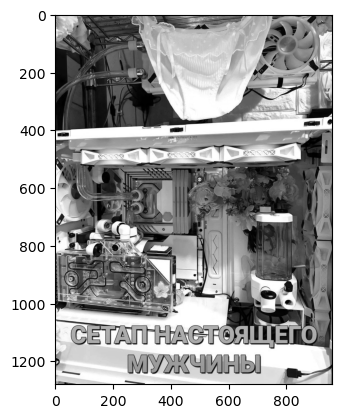

In [39]:
plt.imshow(grayImage, cmap='gray')

tensor([2])

In [82]:
s = val_set[1000]
s[0]

1

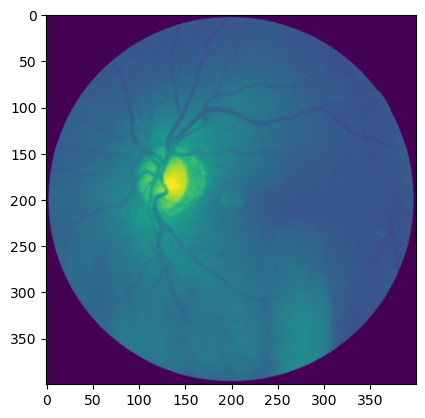

In [83]:
plt.imshow(dataset_utils.prepare_for_vis(s[1]))

In [84]:
model.forward(s[1].unsqueeze(0).to(device))

/home/tiurin/anaconda3/envs/mri_gpu/lib/python3.10/site-packages/torch/nn/functional.py:4227: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


tensor([[ 1.2861, -1.5921]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [69]:
torch.sigmoid)

tensor([[0.7835, 0.1691]], device='cuda:0', grad_fn=<SigmoidBackward0>)